In [1]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agents.rbc import RBC

/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/pyparsing.py:943: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  collections.MutableMapping.register(ParseResults)
/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/xiejiahan/miniforge3/envs/RLinDR/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [3]:
# Simulation without energy storage
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(9)])
cost_no_storage, cost_no_storage_last_yr = env.cost()

In [4]:
env.cost()

({'ramping': 1.0080754,
  '1-load_factor': 1.1489177250436493,
  'average_daily_peak': 1.1131761,
  'peak_demand': 1.1311623,
  'net_electricity_consumption': 0.9870184,
  'carbon_emissions': 0.9963372,
  'total': 1.06411450941648,
  'coordination_score': 1.1003328686846183},
 {'ramping_last_yr': 1.0107086,
  '1-load_factor_last_yr': 1.1559018277706947,
  'average_daily_peak_last_yr': 1.1213595,
  'peak_demand_last_yr': 1.1311623,
  'net_electricity_consumption_last_yr': 0.98786587,
  'carbon_emissions_last_yr': 1.000291,
  'coordination_score_last_yr': 1.1047830378905497,
  'total_last_yr': 1.0731531492227289})

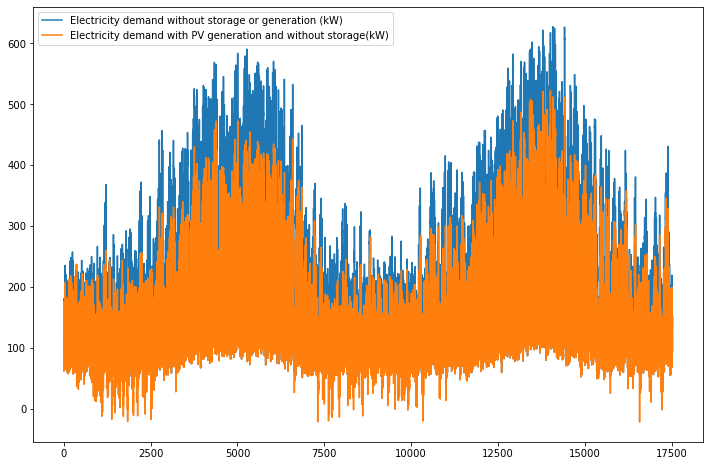

In [5]:
interval = range(sim_period[0], sim_period[1])
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])

In [3]:
# RULE-BASED CONTROLLER (RBC) (Stores energy at night and releases it during the day)
# In this example, each building has its own RBC, which tries to flatten a generic building load 
# by storing energy at night and using it during the day, which isn't necessarily the best solution 
# in order to flatten the total load of the district.
# Select the climate zone and load environment

'''IMPORTANT: Make sure that the buildings_state_action_space.json file contains the hour of day as 3rd true state:
{"Building_1": {
    "states": {
        "month": true,
        "day": true,
        "hour": true
Alternative, modify the line: "hour_day = states[0][2]" of the RBC_Agent Class in agent.py
'''
import json
import time
# Instantiating the control agent(s)
agents = RBC(actions_spaces)

# Finding which state 
with open('buildings_state_action_space.json') as file:
    actions_ = json.load(file)

indx_hour = -1
for obs_name, selected in list(actions_.values())[0]['states'].items():
    indx_hour += 1
    if obs_name=='hour':
        break
    assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
        

state = env.reset()
done = False
rewards_list = []
start = time.time()
while not done:
    hour_state = np.array([[state[0][indx_hour]]])
    action = agents.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    rewards_list.append(rewards)
cost_rbc = env.cost()
end = time.time()
print(end-start)

49.267855167388916


In [29]:
1.18602800e-01 + 0.034*2

0.1866028

In [10]:
rbc = np.reshape(env.net_electric_consumption[interval], (-1,116))
print(rbc)

[[323.7737 322.1115 351.0917 371.7138 395.3357 353.6096 328.5904 262.3677
  226.8017 223.8731 279.6033 273.125  217.8176 164.5403 211.4196 161.7025
  195.2575 186.2868 188.1465 193.7198 191.2762 283.302  272.0095 315.6617
  327.5441 348.5595 355.2477 372.8812 434.7778 411.4122 385.4875 375.4441
  376.6575 335.4005 318.9625 313.7217 250.1658 180.7216 227.4733 165.0956
  223.6648 212.3412 197.6519 222.4785 204.087  301.4946 295.3594 356.224
  353.0353 335.7668 381.6552 377.2734 415.6463 405.635  423.1031 402.1713
  398.7761 375.3382 375.8894 353.341  254.6025 191.4801 232.5576 199.0577
  207.6508 207.3153 209.1176 205.625  229.2248 312.1933 266.4296 311.0248
  336.6596 313.5705 322.6912 341.6169 351.2441 382.8197 394.1289 346.6807
  306.0057 181.3219 191.6097 168.2364 184.0278 151.2303 194.4151 178.2287
  197.2343 194.951  177.4394 197.5205 200.0908 220.0108 175.7003 163.3663
  200.521  233.2871 255.5423 248.9829 273.9236 305.0602 268.2192 250.2387
  232.4703 222.5494 226.7839 193.7781 1

In [52]:
action[0][0]=0.034
action[0][1]=0.034
action[0][2]=0.034


In [61]:
next_state, rewards, done, _ = env.step(action)

In [58]:
action[0]

[0.034, 0.034, 0.034]

In [59]:
state[0]

array([ 2.00000000e+00,  1.00000000e+00,  2.40000000e+01,  1.45900000e+01,
        1.50500000e+01,  2.15100000e+01,  1.64700000e+01,  9.00000000e+01,
        9.25800000e+01,  5.90000000e+01,  5.19400000e+01,  0.00000000e+00,
        0.00000000e+00,  1.05840000e+02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  9.46060000e+02,  0.00000000e+00,  2.23500000e+01,
        4.77300000e+01,  1.00400000e+01,  0.00000000e+00,  8.99201374e-01,
        1.31673817e-01,  3.09754795e-02,  1.84077000e+01,  5.47729404e-01])

In [62]:
next_state[0]

array([ 2.00000000e+00,  2.00000000e+00,  1.00000000e+00,  1.44600000e+01,
        1.58600000e+01,  2.22800000e+01,  1.30100000e+01,  9.00000000e+01,
        9.02900000e+01,  5.26400000e+01,  6.70700000e+01,  0.00000000e+00,
        6.94000000e+00,  9.95300000e+01, -0.00000000e+00,  0.00000000e+00,
        5.39900000e+01,  8.91000000e+02, -0.00000000e+00,  2.23000000e+01,
        4.79800000e+01,  1.19400000e+01,  0.00000000e+00,  9.27806166e-01,
        1.64620427e-01,  6.19509642e-02,  1.76386000e+01,  5.42272568e-01])

In [5]:
cost_rbc

({'ramping': 0.902015,
  '1-load_factor': 1.0419496128983476,
  'average_daily_peak': 1.0133967,
  'peak_demand': 1.0282322,
  'net_electricity_consumption': 0.99329144,
  'carbon_emissions': 0.9976307,
  'total': 0.9960859489114281,
  'coordination_score': 0.9963983851181264},
 {'ramping_last_yr': 0.901421,
  '1-load_factor_last_yr': 1.0345666971632994,
  'average_daily_peak_last_yr': 1.0165544,
  'peak_demand_last_yr': 1.0289015,
  'net_electricity_consumption_last_yr': 0.9933153,
  'carbon_emissions_last_yr': 0.99867445,
  'coordination_score_last_yr': 0.9953608802663574,
  'total_last_yr': 0.9955420190172032})

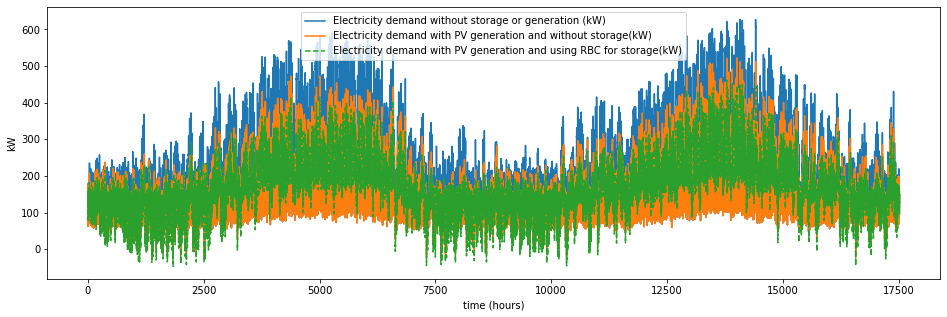

In [9]:
# Plotting electricity consumption breakdown
interval = range(sim_period[0], sim_period[1])
# interval = range(0, 200)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

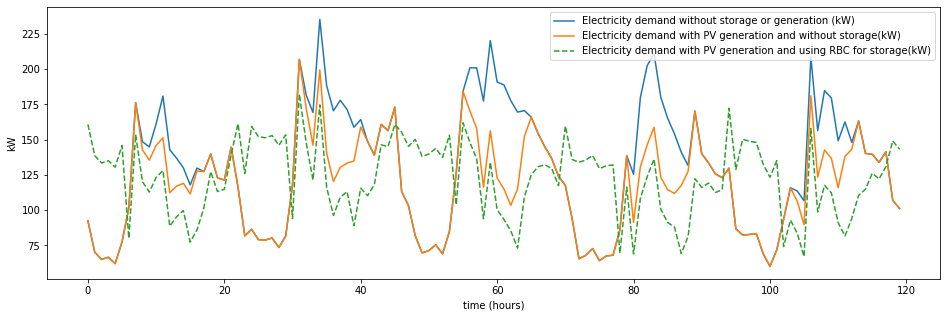

In [10]:
# Plotting 5 days of winter operation of year 1
plt.figure(figsize=(16,5))
interval = range(0,24*5)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

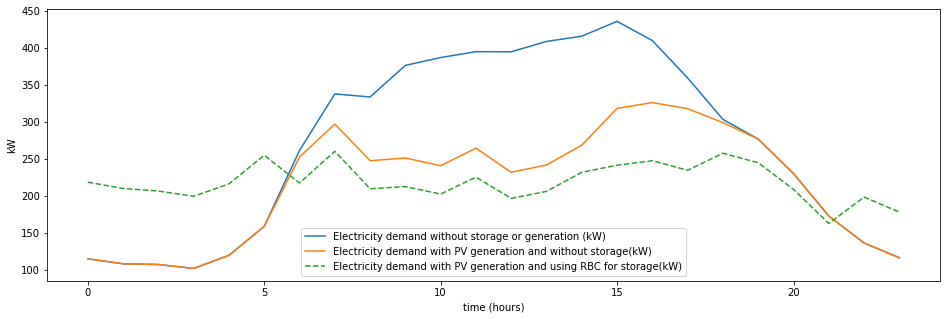

In [10]:
# Plotting summer operation of year 1
plt.figure(figsize=(16,5))
interval = range(24*30*7,24*30*7 + 24)
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

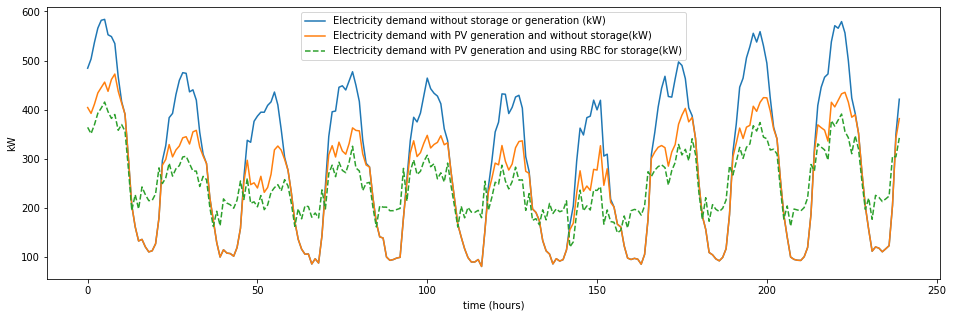

In [11]:
# Plotting summer operation
interval = range(5000,5000 + 24*10)
plt.figure(figsize=(16,5))
plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
plt.plot(env.net_electric_consumption_no_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

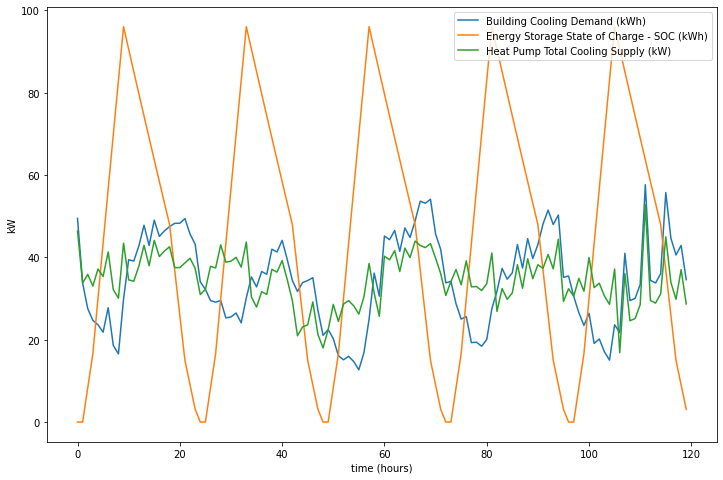

In [11]:
# Plot for one building of the total cooling supply, the state of charge, and the actions of the controller during winter
building_number = 'Building_5'
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_storage_soc[3500:3500+24*5])
plt.plot(env.buildings[building_number].cooling_device_to_building[3500:3500+24*5] + env.buildings[building_number].cooling_device_to_storage[3500:3500+24*5])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Building Cooling Demand (kWh)','Energy Storage State of Charge - SOC (kWh)', 'Heat Pump Total Cooling Supply (kW)'])

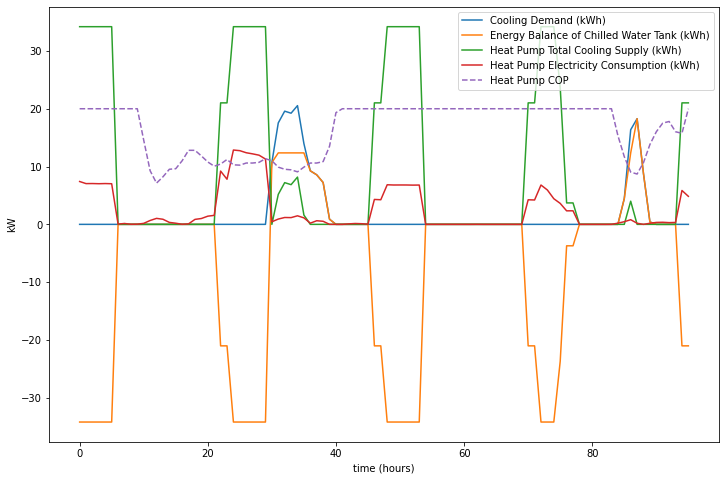

In [12]:
building_number = 'Building_1'
interval = range(0,24*4)
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].cooling_demand_building[interval])
plt.plot(env.buildings[building_number].cooling_storage_to_building[interval] - env.buildings[building_number].cooling_device_to_storage[interval])
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[interval])
plt.plot(env.electric_consumption_cooling[interval])
plt.plot(env.buildings[building_number].cooling_device.cop_cooling[interval],'--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Cooling Demand (kWh)','Energy Balance of Chilled Water Tank (kWh)', 'Heat Pump Total Cooling Supply (kWh)', 'Heat Pump Electricity Consumption (kWh)','Heat Pump COP'])